# This is the notebook explaining the outputs and analysis of the Flint-inspired Agent-Based Model

The model has 6 versions:
- a parameter sweep on model without organizing and static trust
- a model that adds in organizing behavior to the simple version
- a model that adds dynamic trust to the organizing behavior
- the first simple model wtih media connections added
- a model that has static trust, media connections, and organizing behavior
- a model that has dynamic trust, media connections, and organizing behavior

In [3]:
#install packages

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import pandas as pd
import re
import array as arr
from scipy.stats import pearsonr

## Google trends data interpretation

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 4, 3, 2, 9, 23, 100, 57, 38, 27, 14, 12, 13, 19, 15, 9, 7, 7, 7, 11, 9, 9, 6, 5, 3, 3, 3, 3, 3, 3]


Text(0.5, 1.0, 'Google Trends Outputs')

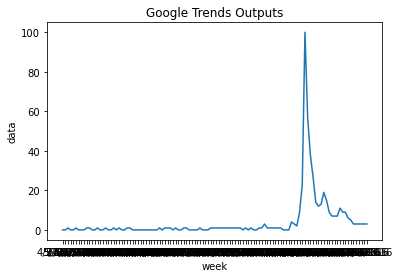

In [4]:
google_trends = pd.read_csv('google-trends.csv')
google_trends.columns = ['week', 'data']
google_data = google_trends['data'].to_list()
print(google_data)
sns.lineplot(data=google_trends, x='week', y='data')
plt.title('Google Trends Outputs')
#plt.show()


### Task 1: Interpret outcomes from csv output 

In [5]:
#load in the csv file
infl_mod = pd.read_csv('static-influence-sweep.csv')
infl_mod.columns = ['run', 'n', 'spread-type', 'simple-spread-chance', 'graph-type', 'ba-m', 'citizen-media-influence',
                  'citizen-citizen-influence','repetition', 'data', 'num_media']


In [6]:
#process the csv and add columns to fill with metrics later

#short list represents both the shortened list to match the google trends data (114 weeks) and the processed data so that it
#is scaled out of 100 to better align with google data
infl_mod["short list"]=None
infl_mod['unscaled-list']=None
#threshold is a binary value representing whether or not the critical mass of the population has been reached (represented by
# 70%)
infl_mod['threshold'] = None
#peak-time is the time at which the peak will occur
infl_mod['peak-time']=None
#total spread is how many agents were reached in sum 
infl_mod['total-spread']=None
#n-week-spread is the largest increase in new agents over a n-week period
infl_mod['1-week-spread']=None
infl_mod['2-week-spread']=None
infl_mod['3-week-spread']=None
infl_mod['4-week-spread']=None
infl_mod['5-week-spread']=None
#total-error is the total error
infl_mod['total-error']=None
#r is caluclated as pearson's r
infl_mod['r']= None


'''The three functions below are needed for data processing'''

def convertdata(data):
    sdata = data.strip(' ')
    ndata = nlogo_parse_chunk(sdata)
    n2data = [elem.replace('.', '') for elem in ndata]
    list=[]
    for x in n2data:
        list.append(x.replace("\r\n", ""))
    list = [i for i in list if i]
    return list

def nlogo_parse_chunk(chunk):
    chunk = chunk.strip().replace('"','')
    if chunk.count('[') > 1 and chunk[0] == '[':
        return nlogo_mixed_list_to_dict_rec(chunk[chunk.index('['):].strip())
    elif chunk.count('[') > 1 or chunk[0] != '[':
        return { chunk[0:chunk.index('[')].strip(): nlogo_mixed_list_to_dict_rec(chunk[chunk.index('['):].strip()) }

    pieces = chunk.strip().replace('[','').replace(']','').split(' ')
    if len(pieces) == 2:
        return { pieces[0]: pieces[1] }
    else:
        return pieces

def convert_to_int(data):
    for i in range(0, len(data)):
        data[i] = int(data[i])
    return data



'''This section goes through each simulation to update the dataframe with usable data and the metrics set up above'''
for i in range(0,infl_mod.shape[0]):
    thresh=0
    error=0
    delta_max_1=0
    delta_max_2=0
    delta_max_3=0
    delta_max_4=0
    delta_max_5=0
    
    #set cutoff to the number of agents that need to hear about Flint to be considered a success- for this model, total runs are 
    #500 agents, so 350 represents 70% of them
    cutoff= (300 + int(infl_mod['num_media'].iloc[i])) * 0.7
    
    run1 = infl_mod["data"].iloc[i]
    finallist = convertdata(run1)
    int_data = convert_to_int(finallist)
    short_list=int_data[: 114]
    infl_mod['unscaled-list'].iloc[i] = short_list
    scaled_short_list=[]
        #code below scales data from 0-100 to match google trends- this is needed to calculate total error, pearson's r, etc
    if max(short_list)>= 1:
        for k in range(0, len(short_list)):
            val=(short_list[k]/max(short_list))*100
            scaled_short_list.append(val)
        time_of_peak=short_list.index(max(short_list))
    else:
        for k in range(0, len(short_list)):
            val = (short_list[k] / 1) * 100
            scaled_short_list.append(val)
    infl_mod['short list'].iloc[i] = scaled_short_list
    for h in range(0, len(scaled_short_list)):
        thresh=thresh+int_data[h]
        error_addition=abs(scaled_short_list[h]-google_data[h])
        error=error+error_addition
    #since thresh is untransformed, we tabulate off of raw data cut to 114 weeks, not the scaled 0-100 data
    infl_mod['total-spread'].iloc[i] = thresh
    if thresh >= cutoff:
        infl_mod['threshold'].iloc[i] = 1
    else:
        infl_mod['threshold'].iloc[i] = 0
    for a in range(1, len(scaled_short_list)):
        delta_1 = scaled_short_list[a] - scaled_short_list[a-1]
        if delta_1 > delta_max_1:
            delta_max_1 = delta_1
        else:
            pass
    for j in range(2, len(scaled_short_list)):
        delta_2 = scaled_short_list[j] - scaled_short_list[j-2]
        if delta_2 > delta_max_2:
            delta_max_2 = delta_2
        else:
            pass
    for b in range(3, len(scaled_short_list)):
        delta_3 = scaled_short_list[b] - scaled_short_list[b-3]
        if delta_3 > delta_max_3:
            delta_max_3 = delta_3
        else:
            pass
    for c in range(4, len(scaled_short_list)):
        delta_4 = scaled_short_list[c] - scaled_short_list[c-4]
        if delta_4 > delta_max_4:
            delta_max_4 = delta_4
        else:
            pass
    for d in range(5, len(scaled_short_list)):
        delta_5 = scaled_short_list[d] - scaled_short_list[d-5]
        if delta_5 > delta_max_5:
            delta_max_5 = delta_5
        else:
            pass
    
    
    corr_coef=pearsonr(google_data,scaled_short_list)
    corr_val=corr_coef[0]
    infl_mod['r'].iloc[i] = corr_val
    infl_mod["total-error"].iloc[i]=error
    infl_mod['peak-time'].iloc[i]=time_of_peak
    infl_mod['1-week-spread'].iloc[i] = delta_max_1
    infl_mod['2-week-spread'].iloc[i] = delta_max_2
    infl_mod['3-week-spread'].iloc[i] = delta_max_3
    infl_mod['4-week-spread'].iloc[i] = delta_max_4
    infl_mod['5-week-spread'].iloc[i] = delta_max_5
        #2-week spread
        
    if i % 5000 == 0:
        print(i)

infl_mod.to_csv('influence_mod_with_metrics.csv')


 

     

C:\Users\cknox\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\cknox\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0
5000


KeyboardInterrupt: 

# Analysis

In [1]:
'''WHAT ARE THE RANGES OF EACH OF OUR METRICS?'''
#Note: this analysis uses all simulations, not limited to those that crossed the threshold. Because of this, there bin for peak
#spread = 100 is inflated, because this includes runs that went something like [0,0,0,0,1,0,0,0]



figure, axis = plt.subplots(1, 4, figsize= (30,10))

# For peak time
axis[0].hist(infl_mod['peak-time'], bins=50)
axis[0].vlines(91, 0, 1200, color = 'red', label = 'google peak')
axis[0].set_title("Histogram of the time of Peak", size=20)
axis[0].legend()
axis[0].tick_params(axis='both', which='major', labelsize=22)
  
# For total-spread
axis[1].hist(infl_mod['total-spread'], bins=50)
axis[1].set_title("Histogram of the total spread", size=20)
axis[1].tick_params(axis='both', which='major', labelsize=22)

# For pearson's r
axis[2].hist(infl_mod['r'], bins=50)
axis[2].set_title("Histogram of Pearson's R", size=20)
axis[2].tick_params(axis='both', which='major', labelsize=22)

# For total error
axis[3].hist(infl_mod['total-error'], bins=50)
axis[3].set_title("Histogram of Total Error", size=20)
axis[3].tick_params(axis='both', which='major', labelsize=22)
  
# Combine all the operations and display

#figure, axis = plt.subplots(2, 3, figsize= (40,30))
plt.tick_params(axis='both', which='major', labelsize=22)
# For 1-week-spread
axis[0,0].hist(infl_mod['1-week-spread'], bins=50)
axis[0,0].set_title("1 Week Spread", size=20)
axis[0,0].tick_params(axis='both', which='major', labelsize=22)

# For 2-week-spread
axis[0,1].hist(infl_mod['2-week-spread'], bins=50)
axis[0,1].set_title("2 Week Spread", size=20)
axis[0,1].tick_params(axis='both', which='major', labelsize=22)

  
# For 3-week-spread
axis[0,2].hist(infl_mod['3-week-spread'], bins=50)
axis[0,2].set_title("3 Week Spread", size=20)
axis[0,2].tick_params(axis='both', which='major', labelsize=22)


# For 4-week-spread
axis[1,0].hist(infl_mod['4-week-spread'], bins=50)
axis[1,0].set_title("4 Week Spread", size=20)
axis[1,0].tick_params(axis='both', which='major', labelsize=22)

  
    
# For 5-week-spread
axis[1,1].hist(infl_mod['5-week-spread'], bins=50)
axis[1,1].set_title("5 Week Spread", size=20)
axis[1,1].tick_params(axis='both', which='major', labelsize=22)

NameError: name 'plt' is not defined

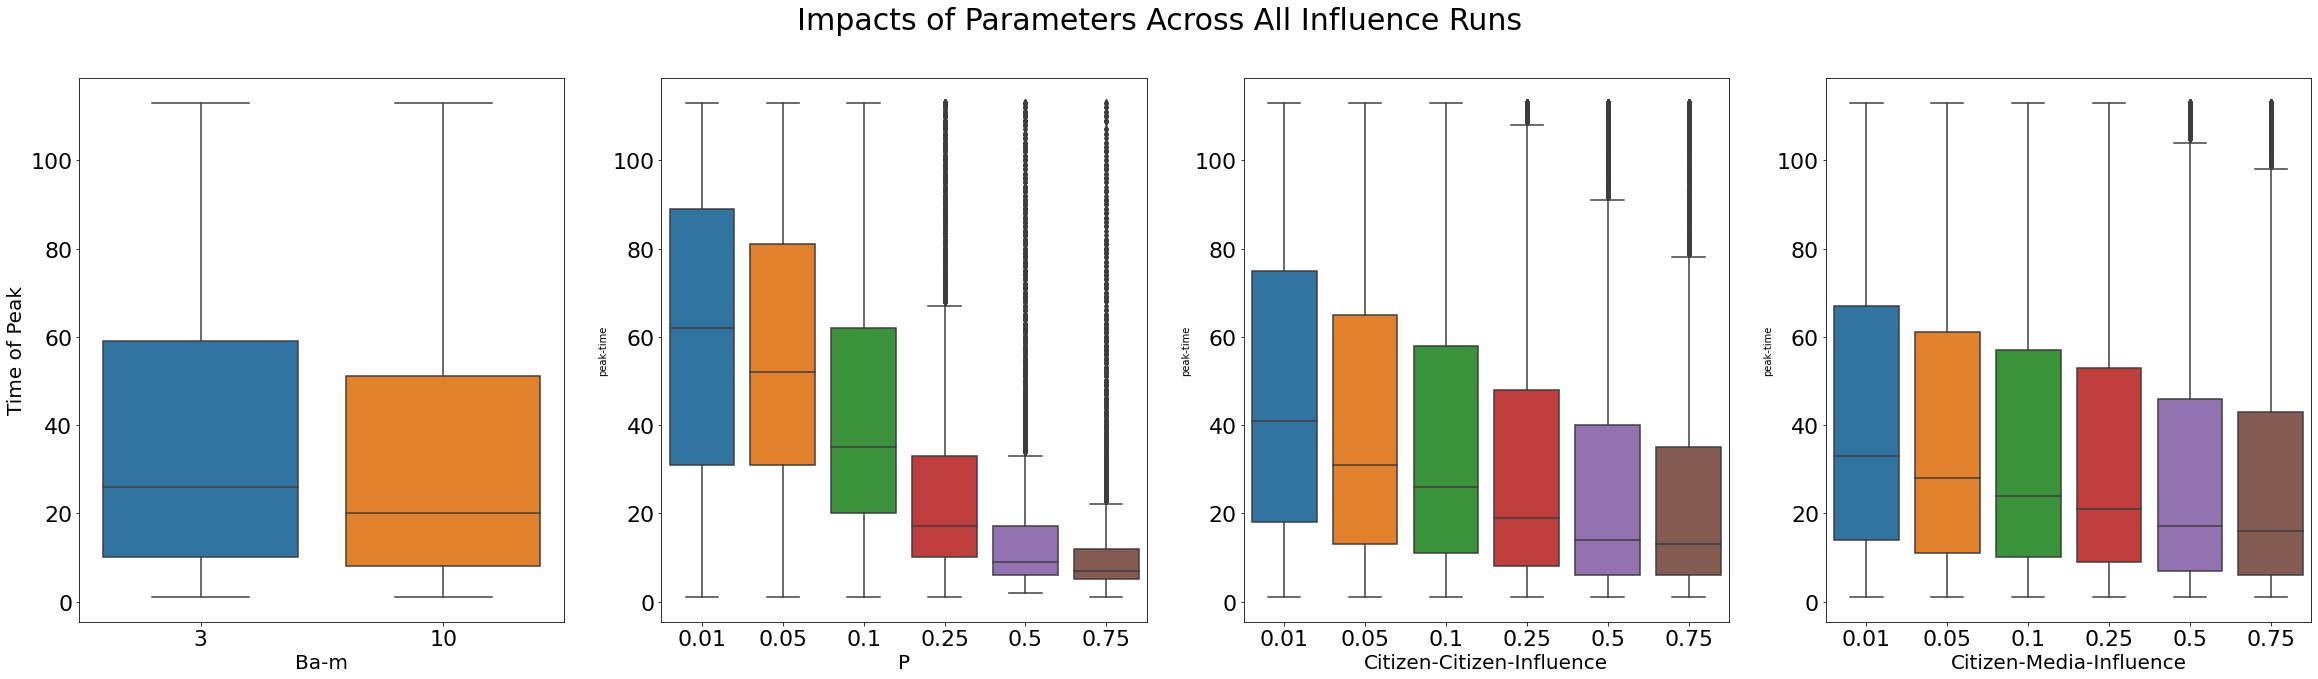

In [17]:
#Now we can explore how each parameter affected each metric
infl_mod = pd.read_csv("influence_mod_with_metrics.csv")
    
fig, axes=plt.subplots(1,4, figsize= (40,10))
fig.suptitle('Impacts of Parameters Across All Influence Runs', fontsize=30)

sns.boxplot(ax=axes[0], data= infl_mod, x='ba-m', y='peak-time')
axes[0].set_xlabel("Ba-m", fontsize=20)
axes[0].set_ylabel("Time of Peak", fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1], data= infl_mod, x='simple-spread-chance', y='peak-time')
axes[1].set_xlabel("P", fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=22)


sns.boxplot(ax=axes[2], data= infl_mod, x='citizen-citizen-influence', y='peak-time')
axes[2].set_xlabel("Citizen-Citizen-Influence", fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=22)


sns.boxplot(ax=axes[3], data= infl_mod, x='citizen-media-influence', y='peak-time')
axes[3].set_xlabel("Citizen-Media-Influence", fontsize=20)
axes[3].tick_params(axis='both', which='major', labelsize=22)


plt.savefig("Boxplots_all_runs_infl.png")







Visually, we see that Ba-M has a strong impact really only on total information spread and a slight impact on time of peak. This makes sense because ba-m affects the intiial connectivity of the graph.

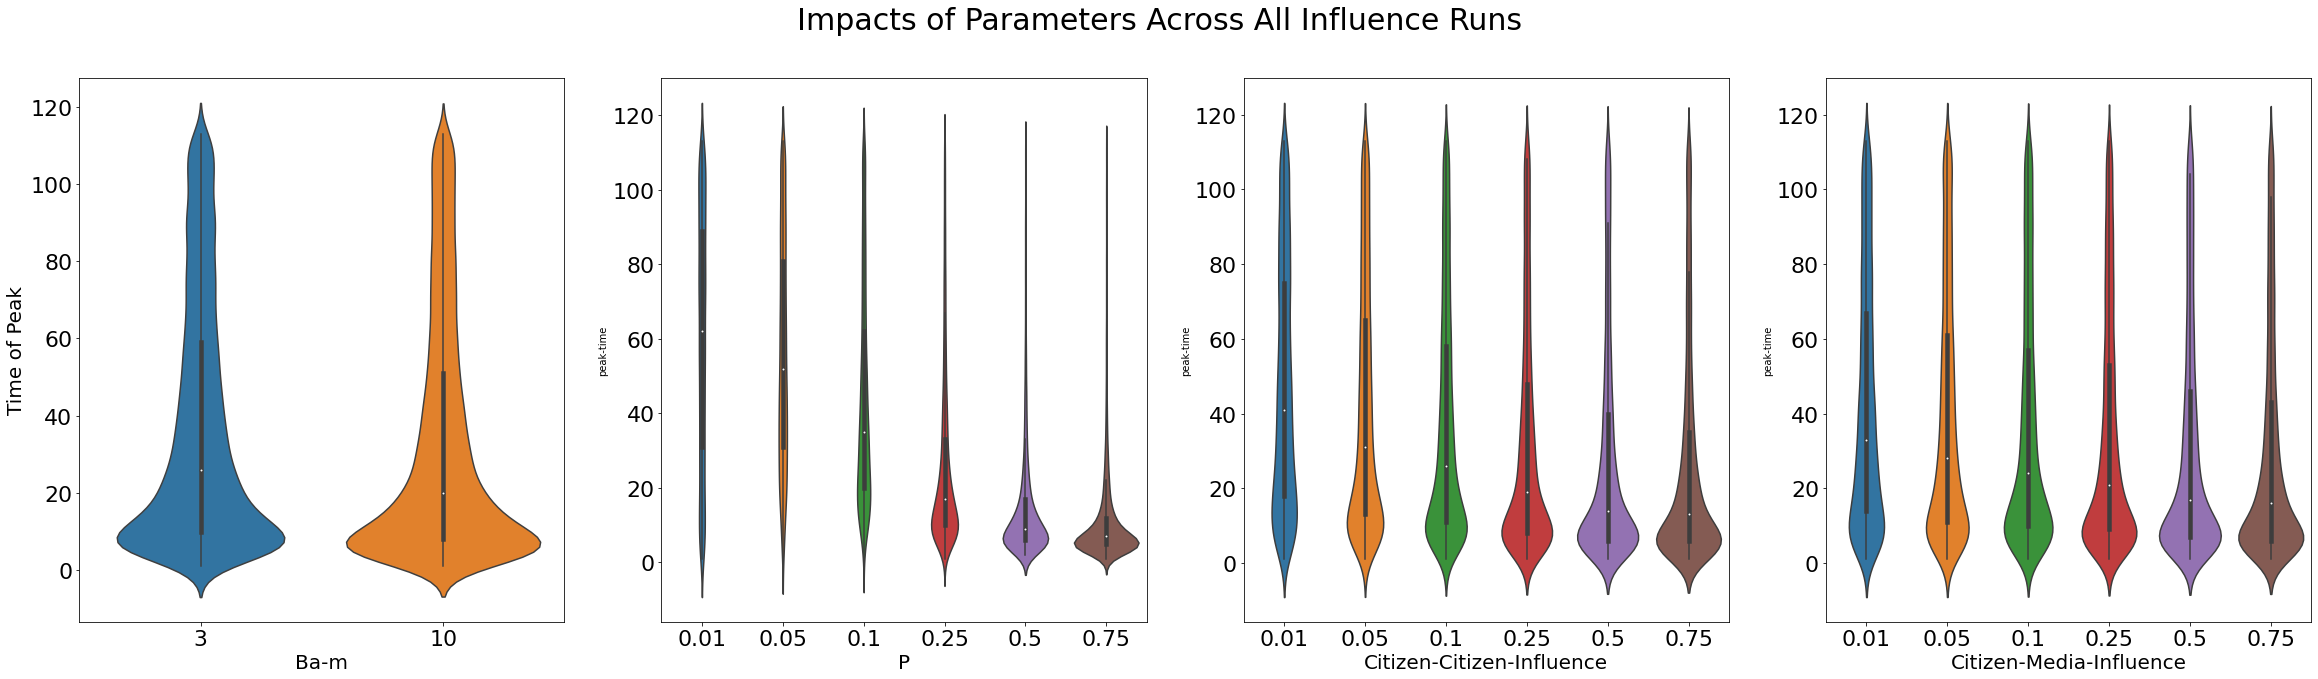

In [16]:
fig, axes=plt.subplots(1,4, figsize= (40,10))
fig.suptitle('Impacts of Parameters Across All Influence Runs', fontsize=30)

sns.violinplot(ax=axes[0], data= infl_mod, x='ba-m', y='peak-time')
axes[0].set_xlabel("Ba-m", fontsize=20)
axes[0].set_ylabel("Time of Peak", fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=22)

sns.violinplot(ax=axes[1], data= infl_mod, x='simple-spread-chance', y='peak-time')
axes[1].set_xlabel("P", fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=22)


sns.violinplot(ax=axes[2], data= infl_mod, x='citizen-citizen-influence', y='peak-time')
axes[2].set_xlabel("Citizen-Citizen-Influence", fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=22)


sns.violinplot(ax=axes[3], data= infl_mod, x='citizen-media-influence', y='peak-time')
axes[3].set_xlabel("Citizen-Media-Influence", fontsize=20)
axes[3].tick_params(axis='both', which='major', labelsize=22)


plt.savefig("violinplots_all_runs_infl.png")





In [6]:

#simple-spread chance
#fig, axes=plt.subplots(3,3, figsize= (30,30))
fig.suptitle('Impacts of simple spread chance on Outcomes', fontsize=30)

sns.boxplot(ax=axes[0,0], data= infl_mod, x='simple-spread-chance', y='1-week-spread')
axes[0,0].set_xlabel("simple-spread-chance", fontsize=20)
axes[0,0].set_ylabel("1-weeks-spread", fontsize=20)
axes[0,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[0,1], data= infl_mod, x='simple-spread-chance', y='2-week-spread')
axes[0,1].set_xlabel("simple-spread-chance", fontsize=20)
axes[0,1].set_ylabel("2-weeks-spread", fontsize=20)
axes[0,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[0,2], data= infl_mod, x='simple-spread-chance', y='3-week-spread')
axes[0,2].set_xlabel("simple-spread-chance", fontsize=20)
axes[0,2].set_ylabel("3-weeks-spread", fontsize=20)
axes[0,2].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,0], data= infl_mod, x='simple-spread-chance', y='4-week-spread')
axes[1,0].set_xlabel("simple-spread-chance", fontsize=20)
axes[1,0].set_ylabel("4-weeks-spread", fontsize=20)
axes[1,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,1], data= infl_mod, x='simple-spread-chance', y='5-week-spread')
axes[1,1].set_xlabel("simple-spread-chance", fontsize=20)
axes[1,1].set_ylabel("5-weeks-spread", fontsize=20)
axes[1,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,2], data= infl_mod, x='simple-spread-chance', y='total-error')
axes[1,2].set_xlabel("simple-spread-chance", fontsize=20)
axes[1,2].set_ylabel("Total Error", fontsize=20)
axes[1,2].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,0], data= infl_mod, x='simple-spread-chance', y='r')
axes[2,0].set_xlabel("simple-spread-chance", fontsize=20)
axes[2,0].set_ylabel("Pearson's R", fontsize=20)
axes[2,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,1], data= infl_mod, x='simple-spread-chance', y='peak-time')
axes[2,1].set_xlabel("simple-spread-chance", fontsize=20)
axes[2,1].set_ylabel("Time of Peak", fontsize=20)
axes[2,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,2], data= infl_mod, x='simple-spread-chance', y='total-spread')
axes[2,2].set_xlabel("simple-spread-chance", fontsize=20)
axes[2,2].set_ylabel("Total Information Spread", fontsize=20)
axes[2,2].tick_params(axis='both', which='major', labelsize=22)

#citizen-citizen-influence


#citizen-media-influence



NameError: name 'fig' is not defined

Here, patterns are unclear in the x-week-spread (perhaps would flatten with a larger number of runs. However, there are significant impacts due to time of peak and total spread.

In [7]:
#citizen-citizen-influence
#fig, axes=plt.subplots(3,3, figsize= (30,30))
fig.suptitle('Impacts of citizen-citizen-influence on Outcomes', fontsize=30)

sns.boxplot(ax=axes[0,0], data= infl_mod, x='citizen-citizen-influence', y='1-week-spread')
axes[0,0].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[0,0].set_ylabel("1-weeks-spread", fontsize=20)
axes[0,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[0,1], data= infl_mod, x='citizen-citizen-influence', y='2-week-spread')
axes[0,1].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[0,1].set_ylabel("2-weeks-spread", fontsize=20)
axes[0,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[0,2], data= infl_mod, x='citizen-citizen-influence', y='3-week-spread')
axes[0,2].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[0,2].set_ylabel("3-weeks-spread", fontsize=20)
axes[0,2].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,0], data= infl_mod, x='citizen-citizen-influence', y='4-week-spread')
axes[1,0].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[1,0].set_ylabel("4-weeks-spread", fontsize=20)
axes[1,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,1], data= infl_mod, x='citizen-citizen-influence', y='5-week-spread')
axes[1,1].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[1,1].set_ylabel("5-weeks-spread", fontsize=20)
axes[1,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,2], data= infl_mod, x='citizen-citizen-influence', y='total-error')
axes[1,2].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[1,2].set_ylabel("Total Error", fontsize=20)
axes[1,2].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,0], data= infl_mod, x='citizen-citizen-influence', y='r')
axes[2,0].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[2,0].set_ylabel("Pearson's R", fontsize=20)
axes[2,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,1], data= infl_mod, x='citizen-citizen-influence', y='peak-time')
axes[2,1].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[2,1].set_ylabel("Time of Peak", fontsize=20)
axes[2,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,2], data= infl_mod, x='citizen-citizen-influence', y='total-spread')
axes[2,2].set_xlabel("citizen-citizen-influence", fontsize=20)
axes[2,2].set_ylabel("Total Information Spread", fontsize=20)
axes[2,2].tick_params(axis='both', which='major', labelsize=22)


NameError: name 'fig' is not defined

We see the biggest impact in total information spread, but this parameter also appears to affect spread in a discernable way.

In [8]:
#citizen-media-influence
#fig, axes=plt.subplots(3,3, figsize= (30,30))
fig.suptitle('Impacts of citizen-media-influence on Outcomes', fontsize=30)

sns.boxplot(ax=axes[0,0], data= infl_mod, x='citizen-media-influence', y='1-week-spread')
axes[0,0].set_xlabel("citizen-media-influence", fontsize=20)
axes[0,0].set_ylabel("1-weeks-spread", fontsize=20)
axes[0,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[0,1], data= infl_mod, x='citizen-media-influence', y='2-week-spread')
axes[0,1].set_xlabel("citizen-media-influence", fontsize=20)
axes[0,1].set_ylabel("2-weeks-spread", fontsize=20)
axes[0,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[0,2], data= infl_mod, x='citizen-media-influence', y='3-week-spread')
axes[0,2].set_xlabel("citizen-media-influence", fontsize=20)
axes[0,2].set_ylabel("3-weeks-spread", fontsize=20)
axes[0,2].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,0], data= infl_mod, x='citizen-media-influence', y='4-week-spread')
axes[1,0].set_xlabel("citizen-media-influence", fontsize=20)
axes[1,0].set_ylabel("4-weeks-spread", fontsize=20)
axes[1,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,1], data= infl_mod, x='citizen-media-influence', y='5-week-spread')
axes[1,1].set_xlabel("citizen-media-influence", fontsize=20)
axes[1,1].set_ylabel("5-weeks-spread", fontsize=20)
axes[1,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[1,2], data= infl_mod, x='citizen-media-influence', y='total-error')
axes[1,2].set_xlabel("citizen-media-influence", fontsize=20)
axes[1,2].set_ylabel("Total Error", fontsize=20)
axes[1,2].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,0], data= infl_mod, x='citizen-media-influence', y='r')
axes[2,0].set_xlabel("citizen-media-influence", fontsize=20)
axes[2,0].set_ylabel("Pearson's R", fontsize=20)
axes[2,0].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,1], data= infl_mod, x='citizen-media-influence', y='peak-time')
axes[2,1].set_xlabel("citizen-media-influence", fontsize=20)
axes[2,1].set_ylabel("Time of Peak", fontsize=20)
axes[2,1].tick_params(axis='both', which='major', labelsize=22)

sns.boxplot(ax=axes[2,2], data= infl_mod, x='citizen-media-influence', y='total-spread')
axes[2,2].set_xlabel("citizen-media-influence", fontsize=20)
axes[2,2].set_ylabel("Total Information Spread", fontsize=20)
axes[2,2].tick_params(axis='both', which='major', labelsize=22)


NameError: name 'fig' is not defined